<center>
<a href="http://www.insa-toulouse.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/logo-insa.jpg" style="float:left; max-width: 120px; display: inline" alt="INSA"/></a> 

<a href="http://wikistat.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/wikistat.jpg" style="max-width: 250px; display: inline"  alt="Wikistat"/></a>

<a href="http://www.math.univ-toulouse.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/logo_imt.jpg" style="float:right; max-width: 250px; display: inline" alt="IMT"/> </a>
</center>

# Adaptation Statistique d'un Modèle de Prévision du Pic d'Ozone en <a href="https://www.python.org/"><img src="https://upload.wikimedia.org/wikipedia/commons/thumb/f/f8/Python_logo_and_wordmark.svg/390px-Python_logo_and_wordmark.svg.png" style="max-width: 120px; display: inline" alt="R"/></a> avec <a href="http://scikit-learn.org/stable/#"><img src="http://scikit-learn.org/stable/_static/scikit-learn-logo-small.png" style="max-width: 100px; display: inline" alt="R"/></a>

**Résumé**: Exploration puis modélisation de données climatiques en utilisant Pyhton et la librairie [Scikit-learn](http://scikit-learn.org/stable/#). L'objectif est de prévoir pour le lendemain un possible dépassement d'un seuil de concentration en ozone à partir d'une prévision déterministe sur un maillage grossier et de variables climatiques locales. Estimation par régression [logistique](http://wikistat.fr/pdf/st-m-app-rlogit.pdf) avec une pénalisation Lasso. Comparaison des [erreurs de prévision](http://wikistat.fr/pdf/st-m-app-risque-estim.pdf) sur un échantillon test puis des courbes ROC et precision-recall.

## 1. Introduction

L'objectif, sur ces données, est d'améliorer la prévision déterministe (MOCAGE), calculée par les services de MétéoFrance,  de la concentration d'ozone dans certaines stations de prélèvement.  Il s'agit d'un problème dit d'*adaptation statistique* ou post-traitement d'une prévision locale de modèles à trop grande échelle en s'aidant d'autre variables également gérées par MétéoFrance, mais à plus petite échelle (température, force du vent...). 

La question posée: peut on améliorer la prévision déterministe avec un modèle statistique. 

On se concentrera sur régression logistique avec une pénalisation Lasso. Suivant la version de Python ou ScikitLearn que vous utilisez, il se peut que certaines commandes ne fonctionnent pas et demandent des modifications.

## 2. Prise en compte des données

Les données ont été extraites et mises en forme par le service concerné de Météo France. Elles sont décrites par les variables suivantes:


* **JOUR** Le type de jour ; férié (1) ou pas (0) ;
* **O3obs** La concentration d'ozone effectivement observée le lendemain à 17h locales correspondant souvent au maximum de pollution observée ;
* **MOCAGE** Prévision de cette pollution obtenue par un modèle déterministe de mécanique des fluides (équation de Navier et Stockes);
* **TEMPE** Température prévue par MétéoFrance pour le lendemain 17h ;
* **RMH2O** Rapport d'humidité ;
* **NO2** Concentration en dioxyde d'azote ;
* **NO** Concentration en monoxyde d'azote ;
* **STATION** Lieu de l'observation : Aix-en-Provence, Rambouillet, Munchhausen, Cadarache et Plan de Cuques ;
* **VentMOD** Force du vent ;
* **VentANG** Orientation du vent. 

Ce sont des données "propres", sans trous, bien codées et de petites tailles. Elles présentent donc avant tout un caractère pédagogique.

Il est choisi ici de lire les données avec la librairie $pandas$ pour bénéficier de la classe DataFrame. Ce n'est pas nécessaire pour l'objectif de prévision car les variables qualitatives ainsi construites ne peuvent être utilisées pour l'interprétation des modèles obtenus dans scikit-learn qui ne reconnaît pas la classe DataFrame.

In [1]:
import pandas as pd
import numpy as np
# Lecture des données
## Charger les données ou les lire directement en précisant le chemin
# path=""
path= ""
ozone=pd.read_csv(path+"depSeuil.dat",sep=",",header=0)
# Vérification du contenu
ozone.head()

,JOUR,O3obs,MOCAGE,TEMPE,RMH2O,NO2,NO,STATION,VentMOD,VentANG
0,1,91,93.2,21.5,0.00847,1.602,0.424,Aix,9.5000,-0.64350
1,1,100,104.6,20.2,0.00881,2.121,0.531,Aix,8.0100,-0.04996
2,0,82,103.6,17.4,0.00951,1.657,0.467,Aix,9.3771,-0.12832
3,0,94,94.8,18.8,0.00855,2.350,0.701,Aix,9.4578,-0.34516
4,0,107,99.0,23.7,0.00731,1.653,0.452,Aix,7.8791,-0.41822


Ce qui suit permet d'affecter le bon type aux variables.

In [2]:
ozone["STATION"]=pd.Categorical(ozone["STATION"],ordered=False)
ozone["JOUR"]=pd.Categorical(ozone["JOUR"],ordered=False)
ozone["O3obs"]=pd.DataFrame(ozone["O3obs"], dtype=float)
ozone.dtypes

JOUR       category
O3obs       float64
MOCAGE      float64
TEMPE       float64
RMH2O       float64
NO2         float64
NO          float64
STATION    category
VentMOD     float64
VentANG     float64
dtype: object

In [3]:
ozone.describe()

,O3obs,MOCAGE,TEMPE,RMH2O,NO2,NO,VentMOD,VentANG
count,1041.000000,1041.000000,1041.000000,1041.000000,1041.000000,1041.000000,1041.000000,1041.000000
mean,115.400576,127.219693,23.883381,0.010251,3.504645,0.657417,5.907186,0.163111
std,40.999155,39.820186,5.217462,0.003731,4.043308,0.844180,3.054307,0.708288
min,19.000000,46.400000,10.400000,0.002850,0.258000,0.001000,0.141420,-1.570790
25%,87.000000,97.500000,20.200000,0.007630,1.248000,0.236000,3.962320,-0.394790
50%,109.000000,125.600000,23.800000,0.009850,2.109000,0.388000,5.597300,0.278300
75%,135.000000,153.600000,27.600000,0.012440,4.062000,0.744000,7.106300,0.692640
max,319.000000,284.700000,38.000000,0.027530,44.396000,9.429000,19.891000,1.570790


## 3. Exploration

Même si les données ne présentent pas de défauts particuliers, une étude exploratoire préliminaire est indispensable afin de s'ssurer le leur bonne cohérence, proposer d'éventuelles transformations et analyser les structures de corrélations ou plus généralement de liaisons entre les variables, de groupes des individus ou observations.

### 3.1 Unidimensionnelle

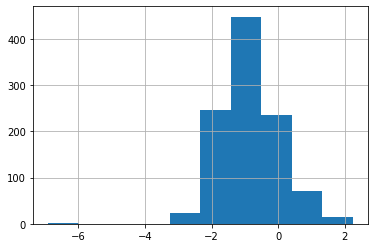

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
np.log(ozone["NO"]).hist()
plt.show()

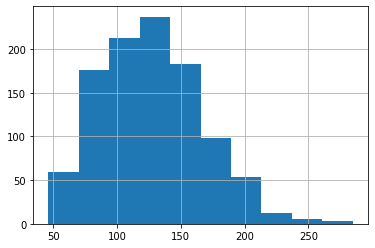

In [5]:
ozone["MOCAGE"].hist()
plt.show()

**Question 1:** Traiter ainsi toutes les variables. Est ce que vos observations suggèrent des transformations? 

Réponse.


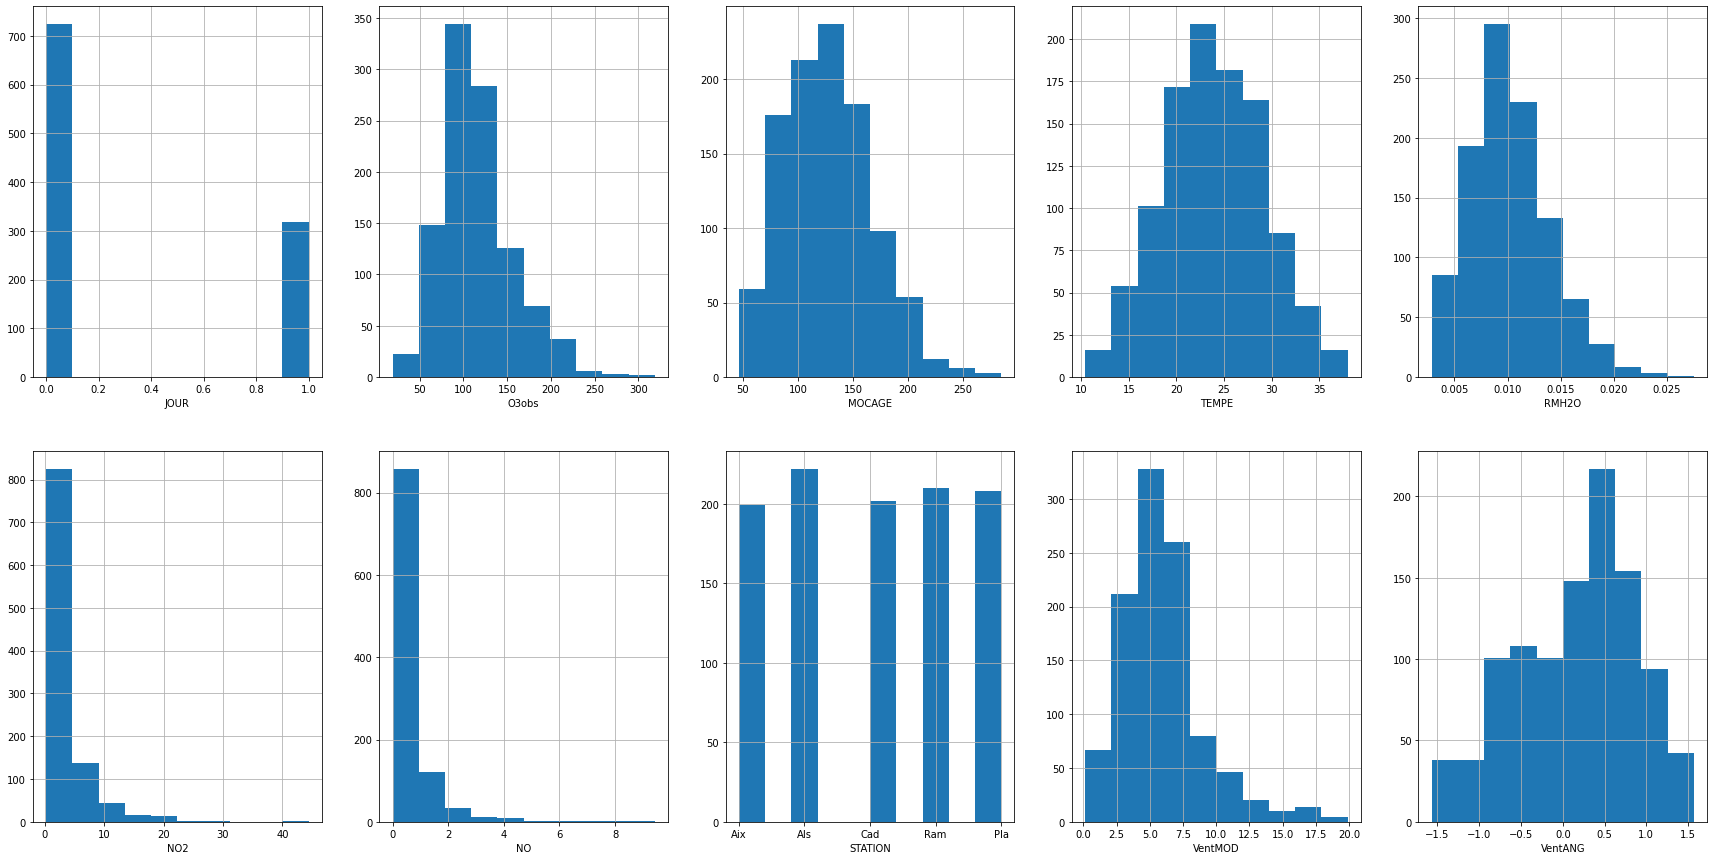

In [6]:
plt.figure(figsize=(30,15))
for i,var in enumerate(ozone.columns):
    plt.subplot(2,5,i+1)
    ozone[var].hist()
    plt.xlabel(var)
plt.show()

--> Les variables "NO" et "NO2" semblent nécessiter une transformation pour mieux observer la diversité des valeurs.


**Question 2:** Vérifier l'opportunité des transformations ci dessous (histogrames des nouvelles variables).

In [7]:
from math import sqrt, log
ozone["SRMH2O"]=ozone["RMH2O"].map(lambda x: sqrt(x))
ozone["LNO2"]=ozone["NO2"].map(lambda x: log(x))
ozone["LNO"]=ozone["NO"].map(lambda x: log(x))


Text(0.5, 0, 'LogNO')

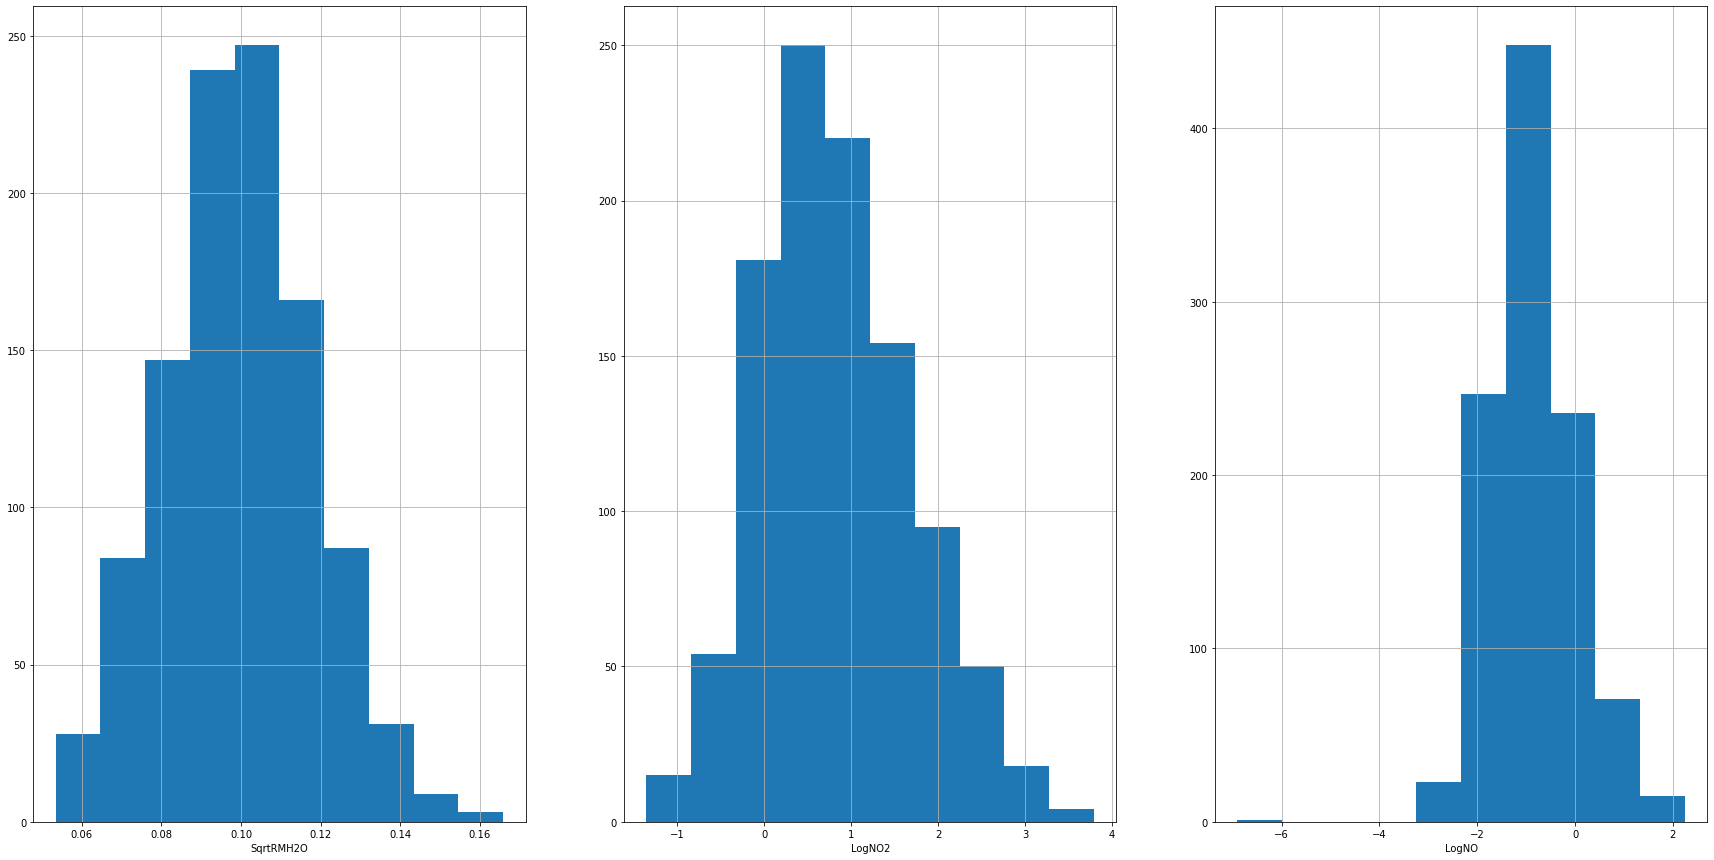

In [8]:
plt.figure(figsize=(30,15))
plt.subplot(1,3,1)
ozone["SRMH2O"].hist()
plt.xlabel("SqrtRMH2O")
plt.subplot(1,3,2)
ozone["LNO2"].hist()
plt.xlabel("LogNO2")
plt.subplot(1,3,3)
ozone["LNO"].hist()
plt.xlabel("LogNO")

On retire les variables initiales et construire ci-dessous la variable "dépassement de seuil" pour obtenir le fichier qui sera effectivement utilisé.

In [9]:
del ozone["RMH2O"]
del ozone["NO2"]
del ozone["NO"]
ozone["DepSeuil"]=ozone["O3obs"].map(lambda x: x > 150)
ozone.head()
ozone.describe()

,O3obs,MOCAGE,TEMPE,VentMOD,VentANG,SRMH2O,LNO2,LNO
count,1041.000000,1041.000000,1041.000000,1041.000000,1041.000000,1041.000000,1041.000000,1041.000000
mean,115.400576,127.219693,23.883381,5.907186,0.163111,0.099568,0.844010,-0.839940
std,40.999155,39.820186,5.217462,3.054307,0.708288,0.018362,0.864939,0.869813
min,19.000000,46.400000,10.400000,0.141420,-1.570790,0.053385,-1.354796,-6.907755
25%,87.000000,97.500000,20.200000,3.962320,-0.394790,0.087350,0.221542,-1.443923
50%,109.000000,125.600000,23.800000,5.597300,0.278300,0.099247,0.746214,-0.946750
75%,135.000000,153.600000,27.600000,7.106300,0.692640,0.111535,1.401675,-0.295714
max,319.000000,284.700000,38.000000,19.891000,1.570790,0.165922,3.793149,2.243790


### 3.2 Exploration multidimensionnelle

**Question 3:** Commenter les résultats suivants. Que dire des relations entre les variables prises 2 à 2 ?

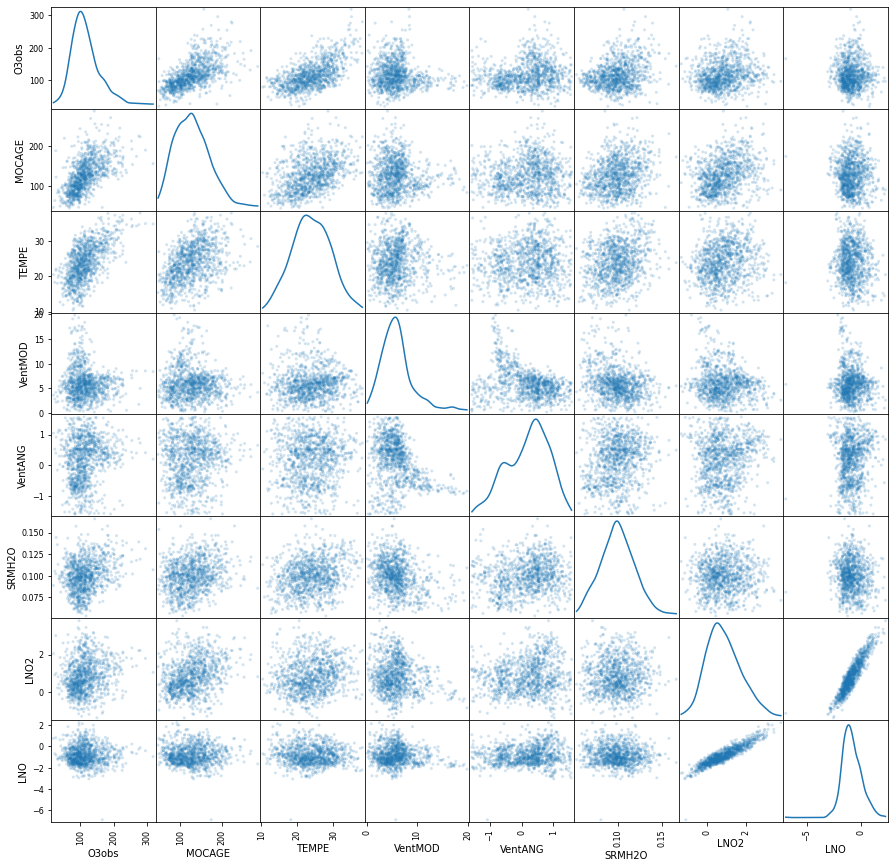

In [10]:
# scatter plot matrix des vaiables quantitatives
from pandas.plotting import scatter_matrix
scatter_matrix(ozone[["O3obs","MOCAGE","TEMPE","VentMOD","VentANG","SRMH2O","LNO2","LNO"]], alpha=0.2, figsize=(15, 15), diagonal='kde')
plt.show()

--> Il ne semble pas exister de relation linéaires simples entre la plupart des variables, à l'exception de "LNO2" et "LNO" pour lesquels une régression linéaire est clairement adaptée.

### 3.3 [Analyse en composantes principales](http://wikistat.fr/pdf/st-m-explo-acp.pdf)

In [11]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
# réduction des variables
X=scale(pd.DataFrame(ozone[["MOCAGE","TEMPE","VentMOD","VentANG","SRMH2O","LNO2","LNO"]]))

Tous les résultats numétriques classiques sont fournis par l'[implémentation](http://scikit-learn.org/stable/modules/decomposition.html) de scikit-learn mais des  efforts sont à produire pour construire les graphiques usuels généralement automatiquement produits par des librairies dédiées comme [FactoMineR](http://factominer.free.fr/) de R.

Les commandes suivantes permettent de réaliser une analyse en composantes principales sur les seules variables quantitatives. Par ailleurs la variable à modéliser  (O3obs, concentration observée) n'est pas utilisée.

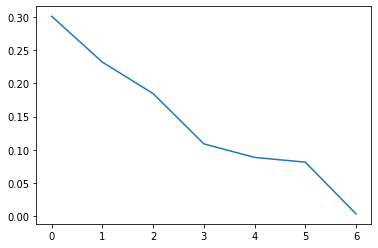

In [12]:
pca = PCA()
## Estimation, calcul des composantes principales
C = pca.fit(X).transform(X)
## Décroissance de la variance expliquée
plt.plot(pca.explained_variance_ratio_)
plt.show()

In [13]:
sum(pca.explained_variance_ratio_[:3])

0.7184058825600542

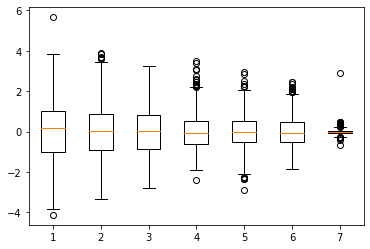

In [14]:
## distribution des composantes principales
plt.boxplot(C[:,0:20])
plt.show()

**Question 4:** Que sont ces graphiques ? Que dire du choix de la dimension, des valeurs atypiques?

--> Le premier graphique montre quelle proportion de la variance est expliquéé par chaque composante obtenue par l'ACP. Le second montre la distribution des données au sein de ces composantes. Ici les 3 premières composantes expliquent 70% de la variance. Celà semble être un bon choix de dimension. Les autres composantes semblent être beaucoup plus impactées par des valeurs singulières.

**Question 5:** Lire et comprendre le code suivant. Que dire de la structure de corrélation des variables ? Est-elle intuitive ? L'objectif est de définir une surface séparant les deux classes. Une discriminaiton linéaire (hyperplan) semble-t-elle possible?

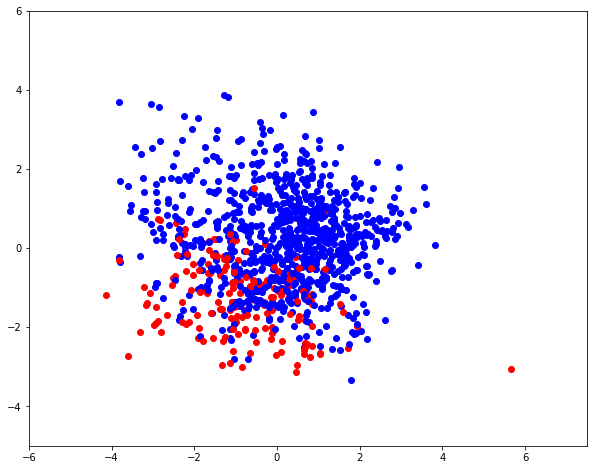

In [15]:
## Repésentation des individus
plt.figure(figsize=(10,8))
for i, j, nom in zip(C[:,0], C[:,1], ozone["DepSeuil"]):
    color = "red" if nom  else "blue"
    plt.plot(i, j, 'o',color=color)
plt.axis((-6,7.5,-5,6))  
plt.show()

--> Il s'agit du premier plan factoriel. On a représenté les valeurs de "DepSeuil" (définie précedemment) en fonction des deux coordonnées principales. Une discrimination linéaire ne semble pas efficace.

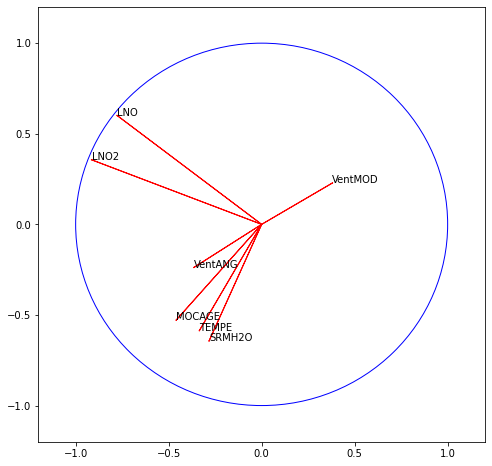

In [16]:
## coordonnées et représentation des variables
coord1=pca.components_[0]*np.sqrt(pca.explained_variance_[0])
coord2=pca.components_[1]*np.sqrt(pca.explained_variance_[1])
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1)
for i, j, nom in zip(coord1,coord2, ozone[["MOCAGE","TEMPE","VentMOD","VentANG","SRMH2O","LNO2","LNO"]].columns):
    plt.text(i, j, nom)
    plt.arrow(0,0,i,j,color='r')
plt.axis((-1.2,1.2,-1.2,1.2))
# cercle
c=plt.Circle((0,0), radius=1, color='b', fill=False)
ax.add_patch(c)
plt.show()

--> Il s'agit du premier cercle des corrélations. VentMOD semble négativement corrélé à la plupart des autres variables.

## 4. Modélisations

L'évaluation d'une méthode de prévision suit généralement le protocole suivant dont la première étape est déja réalisée.


1. Etape descriptive préliminaire uni et multidimensionnelle visant à repérer les incohérences, les variables non significatives ou de distribution exotique, les individus non concernés ou atypiques... et à étudier les structures des données. Ce peut être aussi la longue étape de construction de variables, attributs ou *features* spécifiques des données. 
2. Procéder à un tirage aléatoire d'un échantillon *test* qui ne sera utilisé que lors de la *dernière étape* de comparaison des méthodes.
3. La partie restante est l'échantillon d'*apprentissage* pour l'estimation des paramètres des modèles.
4. Pour chacune des méthodes, optimiser la complexité des modèles en minimisant une estimation "sans biais" de l'erreur de prévision, par exemple par *validation croisée*.
5.  Comparaison des qualités de prévision sur la base du taux de mal classés pour le seul échantillon test qui est resté à l'écart de tout effort ou "acharnement" pour l'optimisation des modèles.

**Remarques**
* En cas d'échantillon relativement "petit" il est recommandé d'itérer la procédure de découpage apprentissage / test, afin de réduire la variance (moyenne) des estimations des erreurs de prévision.
* *Attention*: ne pas "tricher" en modifiant le modèle obtenu lors de l'étape précédente afin d'améliorer le résultat sur l'échantillon test !
* Le critère utilisé dépend du problème : erreur quadratique, taux de mauvais classement, AUC (aire sous la courbe ROC), indice de Pierce, *log loss function*...

### 4.1 Extraction des échantillons apprentissage et test

Transformation des données pour l'apprentissage. Les variables qualitatives sont transformées en paquets d'indicatrices ou *dummy variables* et le type data frame en une matrice. Il est parfois utile, en vue de certaines modélisations de centrer et réduire les variables quantitatives.

In [17]:
ozone.head()

,JOUR,O3obs,MOCAGE,TEMPE,STATION,VentMOD,VentANG,SRMH2O,LNO2,LNO,DepSeuil
0,1,91.0,93.2,21.5,Aix,9.5000,-0.64350,0.092033,0.471253,-0.858022,False
1,1,100.0,104.6,20.2,Aix,8.0100,-0.04996,0.093862,0.751888,-0.632993,False
2,0,82.0,103.6,17.4,Aix,9.3771,-0.12832,0.097519,0.505009,-0.761426,False
3,0,94.0,94.8,18.8,Aix,9.4578,-0.34516,0.092466,0.854415,-0.355247,False
4,0,107.0,99.0,23.7,Aix,7.8791,-0.41822,0.085499,0.502592,-0.794073,False


In [18]:
# Variables explicatives
ozoneDum=pd.get_dummies(ozone[["JOUR","STATION"]])
del ozoneDum["JOUR_0"]
ozoneQuant=ozone[["MOCAGE","TEMPE","VentMOD","VentANG","SRMH2O","LNO2","LNO"]]
dfC=pd.concat([ozoneDum,ozoneQuant],axis=1)
dfC.head()

,JOUR_1,STATION_Aix,STATION_Als,STATION_Cad,STATION_Pla,STATION_Ram,MOCAGE,TEMPE,VentMOD,VentANG,SRMH2O,LNO2,LNO
0,1,1,0,0,0,0,93.2,21.5,9.5000,-0.64350,0.092033,0.471253,-0.858022
1,1,1,0,0,0,0,104.6,20.2,8.0100,-0.04996,0.093862,0.751888,-0.632993
2,0,1,0,0,0,0,103.6,17.4,9.3771,-0.12832,0.097519,0.505009,-0.761426
3,0,1,0,0,0,0,94.8,18.8,9.4578,-0.34516,0.092466,0.854415,-0.355247
4,0,1,0,0,0,0,99.0,23.7,7.8791,-0.41822,0.085499,0.502592,-0.794073


In [19]:
# variable à expliquer binaire
Yb=ozone["DepSeuil"].map(lambda x: int(x))
# variable à expliquer réelle
Yr=ozone["O3obs"]

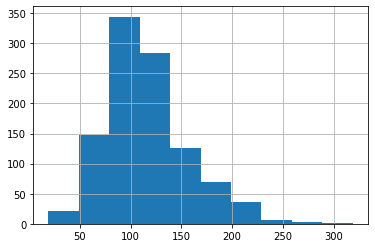

In [20]:
Yr.hist()
plt.show()

Extractions des échantillons d'apprentissage  et test pour les deux types de modèles. Comme le générateur est initalisé de façon identique, ce sont les mêmes échantillons dans les deux cas.

In [21]:
from sklearn.model_selection  import train_test_split
X_train,X_test,Yb_train,Yb_test=train_test_split(dfC,Yb,test_size=200,random_state=11)
X_train,X_test,Yr_train,Yr_test=train_test_split(dfC,Yr,test_size=200,random_state=11)

L'étape suivante est une étape de standardisation des données ou normalisation. Les variables sont divisées par leur écart-type. Ce n'est pas utile dans le cas d'un modèle linéaire élémentaire car la solution est identique mais indispensbale pour beaucoup d'autres méthodes non linéaires (SVM, réseaux de neurones, modèles avec pénalisation). Cette étape est donc concrètement systématiquement exécutée pour éviter des soucis. Attention, les mêmes paramètres (moyennes, écarts-types) estimés sur l'échantillon d'apprentissage sont utilisés pour normaliser l'échantillon test.

In [22]:
from sklearn.preprocessing import StandardScaler  
# L'algorithme ds réseaux de neurones nécessite éventuellement une normalisation 
# des variables explicatives avec les commandes ci-dessous
scaler = StandardScaler()  
scaler.fit(X_train)  
Xr_train = scaler.transform(X_train)  
# Meme transformation sur le test
Xr_test = scaler.transform(X_test)



### 4.2 Performance du modèle Mocage

A titre de comparaison, on trace la prévision de la concentration de l'échantillon test par la seule valeur du modèle *Mocage* ainsi que les résidus à ce modèle fonction de la valeur prédite (Mocage)

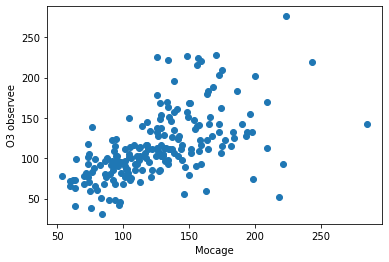

In [23]:
plt.plot(X_test["MOCAGE"],Yr_test,"o")
plt.xlabel("Mocage")
plt.ylabel("O3 observee")
plt.show()

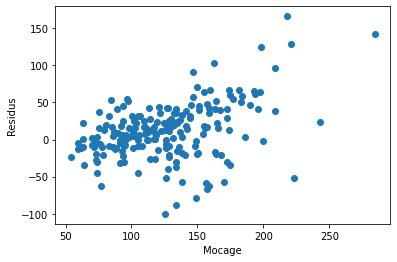

In [24]:
plt.plot(X_test["MOCAGE"],X_test["MOCAGE"]-Yr_test,"o")
plt.xlabel("Mocage")
plt.ylabel("Residus")
plt.show()

**Question 6:** Commenter la qualité de ces résidus. Les commandes suivantes donnent la matrice de confusion concernant l'utilisation du modèle Mocage pour la prédiction de dépassement de seuil. Quelle est le taux d'erreur associé à cette prédiction? Commenter?

--> Les résidus sont du même ordre de grandeur que la variable explicative. La prédiction ne peut donc pas être d'une bonne qualité.

In [25]:
# Prévision
y_chap = X_test["MOCAGE"].map(lambda x: int(x > 150))
# matrice de confusion
table=pd.crosstab(y_chap,Yb_test)
print(table)

DepSeuil    0   1
MOCAGE           
0         134  15
1          33  18


In [26]:
(15 + 33) / (15 + 33 + 134 + 18)

0.24

--> Le calcul ci-dessus permet d'obtenir le taux d'erreur en additionnant les faux-positifs et les faux-négatifs. C'est un taux d'erreur assez important.

### 4.3 [Régression logistique](http://wikistat.fr/pdf/st-m-app-rlogit.pdf) ou modèle binomial

Nous modélisons la variable binaire Yb de dépassement ou non du seuil. Il s'agit d'une régression logistique. On a vu en cours que la complexité du modèle nuit à l'erreur de généralisation. On va ici pénaliser le modèle par une norme l1 des coefficients. 

**Question 7**: Commenter l'effet attendu en minimisant pour y fixé la fonction x-> (y-x)^2+ M |x|^2 pui la fonction x-> (y-x)^2+ M |x| . Cette pénalité est connue sous le nom de Lasso.

--> Il s'agit d'ajouter une régularisation au problème d'optimisation, via une norme L1 ou L2. Cette technique permet au modèle de mieux se généraliser en empêchant les poids de prendre des valeurs trop importantes. La régularisation L1 ou Lasso permet en plus de favoriser la parcimonie du modèle et d'utiliser le moins de coordonnées possible.

**Question 8**: Inspectez les commandes suivantes, quel est le role de la variable C ? Faites le liens avec ce que vous avez vu en cours et la question précédente.

In [27]:
from sklearn.linear_model import LogisticRegression

In [28]:
# Coefficients
C = 0.2
logitLasso=LogisticRegression(penalty="l1",C=C,
                              solver="liblinear")
logitCoef=logitLasso.fit(Xr_train,Yb_train).coef_
print(logitCoef[0])

coef = pd.Series(logitCoef[0], index = X_train.columns)
print("Lasso conserve " + str(sum(coef != 0)) + 
      " variables et en supprime " +  str(sum(coef == 0)))

[ 0.          0.          0.          0.05647527  0.45330856 -0.0729618
  0.55392115  1.73274363 -0.21705542  0.          0.49081053  0.
 -0.01764564]
Lasso conserve 8 variables et en supprime 5


In [29]:
C=5
logitLasso=LogisticRegression(penalty="l1",C=C,solver="liblinear")
logitCoef=logitLasso.fit(Xr_train,Yb_train).coef_
print(logitCoef[0])
coef = pd.Series(logitCoef[0], index = X_train.columns)
print("Lasso conserve " + str(sum(coef != 0)) + 
      " variables et en supprime " +  str(sum(coef == 0)))


[ 0.          0.         -0.25645619  0.12715557  0.80669362 -0.36380997
  0.16841652  2.22748444 -0.60959628  0.03346798  0.59374037  1.24134364
 -1.07760567]
Lasso conserve 11 variables et en supprime 2


In [30]:
C=100
logitLasso=LogisticRegression(penalty="l1",C=C,solver="liblinear")
logitCoef=logitLasso.fit(Xr_train,Yb_train).coef_
print(logitCoef[0])
coef = pd.Series(logitCoef[0], index = X_train.columns)
print("Lasso conserve " + str(sum(coef != 0)) + 
      " variables et en supprime " +  str(sum(coef == 0)))

[-0.00508888 -0.0528903  -0.32742552  0.0810621   0.78024924 -0.43394623
  0.13480068  2.26043985 -0.63628012  0.0367629   0.601554    1.34590086
 -1.16154048]
Lasso conserve 13 variables et en supprime 0


--> C = 1/M dans la avec les notations ci-dessus. Plus C augmente, moins la régularisation est importante.

**Question 9**: Que représente le graphique suivant? Commentez.

c:\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


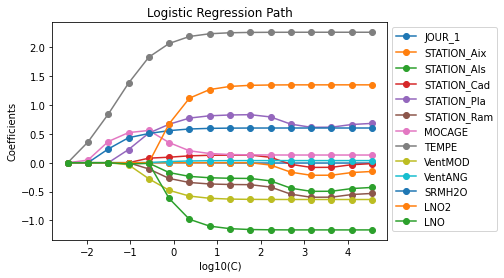

In [31]:
from sklearn.svm import l1_min_c
cs = l1_min_c(Xr_train, Yb_train, loss='log') * np.logspace(0, 7, 16)
coefs_ = []

for c in cs:
    logitLasso.set_params(C=c)
    logitLasso.fit(Xr_train, Yb_train)
    coefs_.append(logitLasso.coef_.ravel().copy())


coefs_ = np.array(coefs_)

for i in range(coefs_.shape[1]):
    plt.plot(np.log10(cs), coefs_[:,i], marker='o', label = dfC.columns[i])

plt.ylim((0.001,100000000))
plt.xlabel('log10(C)')
plt.ylabel('Coefficients')
plt.legend(bbox_to_anchor=(1, 0., 0, 1))
plt.title('Logistic Regression Path')
plt.axis('tight')
plt.show()


--> Il s'agit des valeurs coefficients en fonction de la régularisation. Le choix d'ordre de grandeur de C entre 1 et 100 semble être le choix qui permet la meilleure discrimination.

Nous allons choisir l'hyperparmètre lié à la pénalisation Lasso par validation croisée. Le meilleur modèle est ensuite évalué sur l'échantillon de test pour évaluer le taux d'erreur associé.

In [32]:
from sklearn.model_selection import GridSearchCV
# Optimisation du paramètre de pénalisation
# grille de valeurs
param=[{"C":[0.5,1,5,10,12,15,30]}]
logit = GridSearchCV(LogisticRegression(penalty="l1", solver = "liblinear"), param,cv=5,n_jobs=-1)
logitOpt=logit.fit(Xr_train, Yb_train)
# paramètre optimal
# paramètre optimal
logitOpt.best_params_["C"]
print("Meilleur score = %f, Meilleur paramètre = %s" % (1.-logitOpt.best_score_,logitOpt.best_params_))


Meilleur score = 0.121330, Meilleur paramètre = {'C': 5}


In [33]:
# Estimation du modèle optimal et erreur sur l'échantillon test
coefPenal = logitOpt.best_params_["C"]
typePenal="l1"
nproc=-1
logit = LogisticRegression(penalty=typePenal, dual=False, tol=0.0001, 
            C=coefPenal, fit_intercept=True, intercept_scaling=1, 
            class_weight=None, random_state=None, solver='liblinear', 
            max_iter=100, multi_class='ovr', verbose=0, 
            warm_start=False, n_jobs=nproc)
logitFit=logit.fit(X_train, Yb_train)
# Erreur
1-logitFit.score(X_test, Yb_test)

c:\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1153: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  warnings.warn(


0.13

La matrice de confusion croise les dépassements de seuils prédits avec ceux effectivement observés. 

In [34]:
# Prévision
y_chap = logitFit.predict(Xr_test)
# matrice de confusion
table=pd.crosstab(y_chap,Yb_test)
print(table)

DepSeuil    0   1
row_0            
0         142  20
1          25  13


c:\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


In [37]:
print("Taux d'erreur : ", (25+20)/(142+20+25+13))

Taux d'erreur :  0.225


In [38]:
(142+20+25+13)

200

**Question 10**: commenter la matrice de confusion et le taux d'erreur. Pouvez vous dire si le modèle statistique améliore les prévisions Mocage? Commenter ce résultat

--> Le taux d'erreur est similaire et les performances du modèle ne sont pas satisfaisantes, d'autant plus que simplement prédire 0 tout le temps serait plus efficace.

**Question 11**: Qu'est-ce qu'une courbe ROC? Que représente l'AUC? Commentez l'allure de cette courbe.

--> Une courbe ROC est une mesure de performance d'un modèle par la représentation graphique du taux de vrais positifs par rapport aux faux negatifs. Ici l'allure témoigne du fait qu'on reste tout de même assez éloigné d'une prédiction aléatoire (droite y = x). L'AUC est l'aire sous cette courbe.

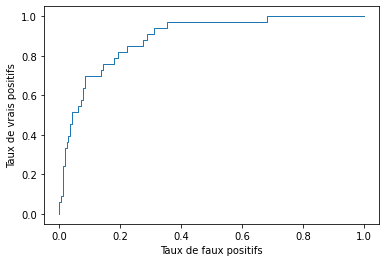

AUC: 0.8918526583197242


In [35]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
probas_ = LogisticRegression(penalty="l1", solver="liblinear",
                    C=logitOpt.best_params_['C']).fit(X_train, Yb_train).predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(Yb_test, probas_[:,1])
plt.plot(fpr, tpr, lw=1)
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.show()
plt.show()

print("AUC: " + str(roc_auc_score(Yb_test, probas_[:,1])))

**Question 12**: Qu'est-ce qu'une courbe precision-recall ? Commenter l'allure de cette courbe et les différences avec la courbe ROC.

--> $$ Precision = \frac{TP}{TP+FP} $$
 $$ Recall = \frac{TP}{TP+FN} $$

 Une courbe précision-recall est simplement une représentation graphique de ces deux métriques en fonction du seuil de décision retenu. Les principes des courbes ROC et PR sont assez proches mais dans certains cas précis une courbe Precision-recall permet de mieux modéliser un problème. Plus de détails sur https://dl.acm.org/doi/10.1145/1143844.1143874

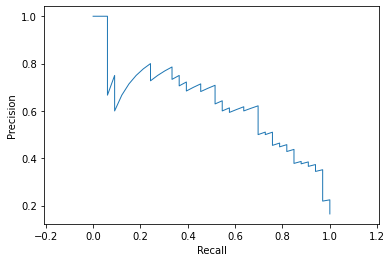

AUC: 0.6323496609362773


In [36]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
probas_ = LogisticRegression(penalty="l1", solver="liblinear",
                    C=logitOpt.best_params_['C']).fit(X_train, Yb_train).predict_proba(X_test)
pr, rec, thresholds = precision_recall_curve(Yb_test, probas_[:,1])
plt.plot(rec, pr, lw=1)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.axis('equal')
plt.show()

print("AUC: " + str(average_precision_score(Yb_test, probas_[:,1] )))